**Context**

Webportals like Bhuvan get vast amount of feedback from the users. To go through all the feedback's can be a tedious job. You have to categorize opinions expressed in feedback forums. This can be utilized for feedback management system. We Classification of individual comments/reviews.and we also determining overall rating based on individual comments/reviews. So that company can get a complete idea on feedback's provided by customers and can take care on those particular fields. This makes more loyal Customers to the company, increase in business , fame ,brand value ,profits.


**Content**

This file has reviewer ID , User ID, Reviewer Name, Reviewer text, helpful, Summary(obtained from Reviewer text),Overall Rating on a scale 5, Review time
Description of columns in the file:

reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B

asin - ID of the product, e.g. 0000013714

reviewerName - name of the reviewer

helpful - helpfulness rating of the review, e.g. 2/3

reviewText - text of the review

overall - rating of the product

summary - summary of the review

unixReviewTime - time of the review (unix time)

reviewTime - time of the review (raw)


**Task**
You have to perform Sentimental Analysis for this data. Help the organization to understand better about their customer feedback's So that they can concentrate on those issues customer's are facing. Build the model which has highest accuracy in classifying the feedback as positive,Negative and neutral.

Task :1
You have to categorize opinions expressed in feedback forums

Task :2
You have to classify individual comments/reviews and you have to determine overall rating based on individual
comments/reviews.

**Inspiration**
This is the Problem Statement given by ISRO to classify the customer comments. This would be helpful for the organization to understand Customer feedbacks.

##### **Importing necessary libraries**

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
import pickle
import random
import os
import re
import nltk  

from nltk.corpus import stopwords  
from imblearn.over_sampling import SMOTE
from dtreeviz.trees import dtreeviz
from IPython.display import Image

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
warnings.filterwarnings('ignore')
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [227]:
#Reading file\
reviews = pd.read_csv('C:\\Users\\Asus\\Desktop\\Amazon-Musical-Instruments-Reviews-main\data\\Musical_instruments_reviews.csv')
reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


#### **1. 1 Data Check**

In [228]:
#Data info
print(reviews.shape)
print()
print(reviews.info())
print()
print(reviews.describe())
print()

(10261, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
reviewerID        10261 non-null object
asin              10261 non-null object
reviewerName      10234 non-null object
helpful           10261 non-null object
reviewText        10254 non-null object
overall           10261 non-null float64
summary           10261 non-null object
unixReviewTime    10261 non-null int64
reviewTime        10261 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None

            overall  unixReviewTime
count  10261.000000    1.026100e+04
mean       4.488744    1.360606e+09
std        0.894642    3.779735e+07
min        1.000000    1.095466e+09
25%        4.000000    1.343434e+09
50%        5.000000    1.368490e+09
75%        5.000000    1.388966e+09
max        5.000000    1.405987e+09



#### **1.2 CHECKING NaN values**

In [229]:
#Checking Reviews
reviews.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

In [230]:
#Dropping NaN values, since we have more than 10k of observations
reviews.dropna(inplace=True)

#### **1.3 DATA AUGMENTATION AND DATA CLEANING**

In [231]:
class Sentiment:
    POSITIVE = "POSITIVE"
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"

#Creating Columns for the year, month and day
def get_year(reviewTime):
    return reviewTime.split(",")[1].strip(" ")

#Function to create 
def get_day(reviewTime):
    return reviewTime.split(" ")[1].strip(",")

#Sentiment Score   
def get_sentiment(score):
    if score <= 2:
        return 'NEGATIVE'
    elif score == 3:
        return 'NEUTRAL'
    else: 
        return 'POSITIVE'
    
def text_clean(text):
    text = str(text).lower()
    text = re.sub(r'@[A-Za-z0-9]','',text)#Removes @mentions
    text = re.sub(r'#','',text)#Removing the Hashtag
    text = re.sub(r'RT[\s]','',text)#Removing RT
    text = re.sub(r'_','',text)#Removing RT
    return text

In [232]:
#Creating Three columns spliiting by year, month and day
reviews['count'] = 1
reviews['year'] = reviews.reviewTime.apply(get_year)
reviews['month'] =  reviews['reviewTime'].str[:2]
reviews['day'] = reviews.reviewTime.apply(get_day)
reviews['Sentiment'] = reviews.overall.apply(get_sentiment)

#Converting Column data type from object to integer
reviews['year'] = reviews['year'].astype('int64')
reviews['month'] = reviews['month'].astype('int64')
reviews['day'] = reviews['day'].astype('int64')

#Cleaning Text
reviews['reviewText'] = reviews['reviewText'].apply(text_clean)

#### **1.4 DATA VISUALIZATION AND ANALYSIS**

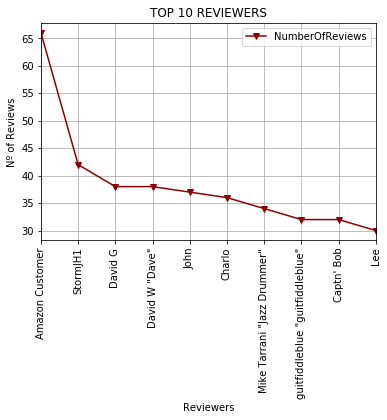

In [233]:
#Top 10 reviewers
top_ten = reviews['reviewerName'].value_counts()
top_ten = top_ten.head(10)
top_ten = pd.DataFrame(top_ten)
top_ten.columns = ['NumberOfReviews']

top_ten.plot(color='darkred',marker='v',linestyle='-')
plt.xticks(rotation=90)
plt.title('TOP 10 REVIEWERS')
plt.grid()
plt.xlabel('Reviewers')
plt.ylabel('Nº of Reviews')
plt.show()

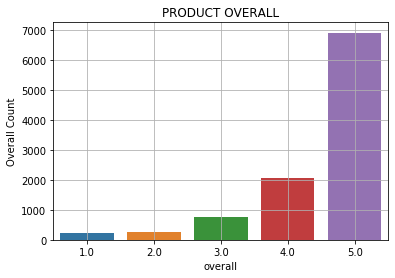

In [234]:
#Product Valuation
sns.countplot(data=reviews, x='overall')
plt.ylabel('Overall Count')
plt.title('PRODUCT OVERALL')
plt.grid()
plt.show()

<Figure size 1008x720 with 0 Axes>

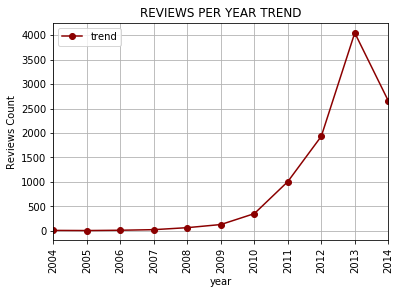

In [235]:
#Grouping By  year
year_review = reviews.groupby(by='year').sum()
year_review = year_review.drop(columns=['month','day','overall','unixReviewTime'])
year_review.columns = ['trend']

#Creating index
#Creating index for the plot
year_index = year_review.index.unique()

#Plot
plt.figure(figsize=(14,10))
year_review.plot(color='darkred',linestyle='-',marker='o')
plt.xticks(year_index,rotation=90)
plt.grid()
plt.ylabel('Reviews Count')
plt.title('REVIEWS PER YEAR TREND')
plt.show()

<Figure size 1008x720 with 0 Axes>

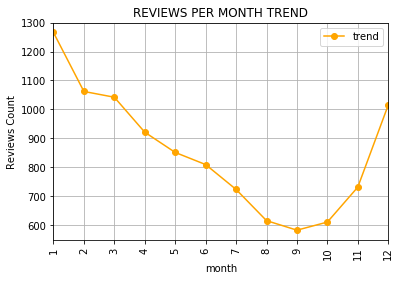

In [236]:
#Grouping By  Month
month_review = reviews.groupby(by='month').sum()
month_review = month_review.drop(columns=['year','day','overall','unixReviewTime'])
month_review.columns = ['trend']

#Creating index for the plot
month_index = month_review.index.unique()

#Creating plot
plt.figure(figsize=(14,10))
month_review.plot(color='orange',linestyle='-',marker='o')
plt.xticks(month_index,rotation=90)
plt.grid()
plt.ylabel('Reviews Count')
plt.title('REVIEWS PER MONTH TREND')
plt.show()

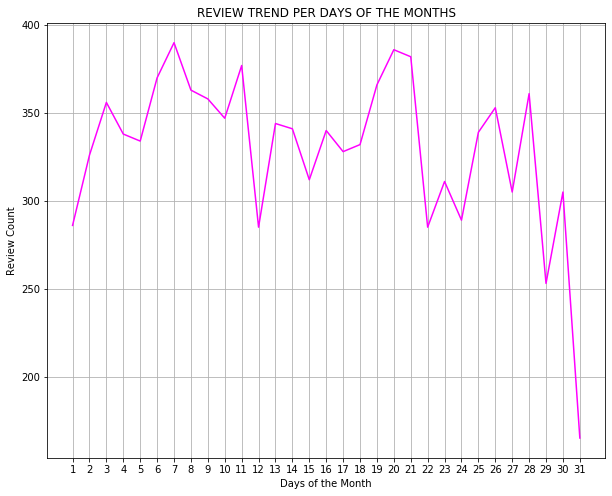

In [237]:
# Trend by day of the month
day = reviews
day = day.sort_values(by=['day'],ascending=True)
day =  day.groupby(by=['day']).sum()
day = day.drop(columns=['overall', 'unixReviewTime','year','month'])
day.columns = ['trend']

# Line plot
plt.figure(figsize=(10,8))
sns.lineplot(data=day, x=day.index, y='trend',color='magenta')
plt.xticks(day.index)
plt.grid()
plt.ylabel('Review Count')
plt.xlabel('Days of the Month')
plt.title('REVIEW TREND PER DAYS OF THE MONTHS')
plt.show()

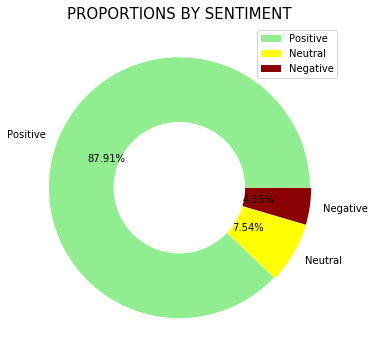

In [238]:
#Reviews Sentiment
size_complete = reviews['Sentiment'].value_counts()
colors_complete = ['lightgreen', 'yellow','darkred']
labels_complete = "Positive", "Neutral","Negative"
explode = [0, 0.01,0.01]

#(0,0) is to create the circle and 0.5 for the width of the circle, white is for the center of the circle
my_circle_complete = plt.Circle((0, 0), 0.5, color = 'white')

plt.figure(figsize=(8,6))
plt.pie(size_complete, colors = colors_complete, labels = labels_complete, shadow = False, explode = explode, autopct = '%.2f%%')
plt.title('PROPORTIONS BY SENTIMENT', fontsize = 15)
p = plt.gcf()
p.gca().add_artist(my_circle_complete)
plt.legend()
plt.show()


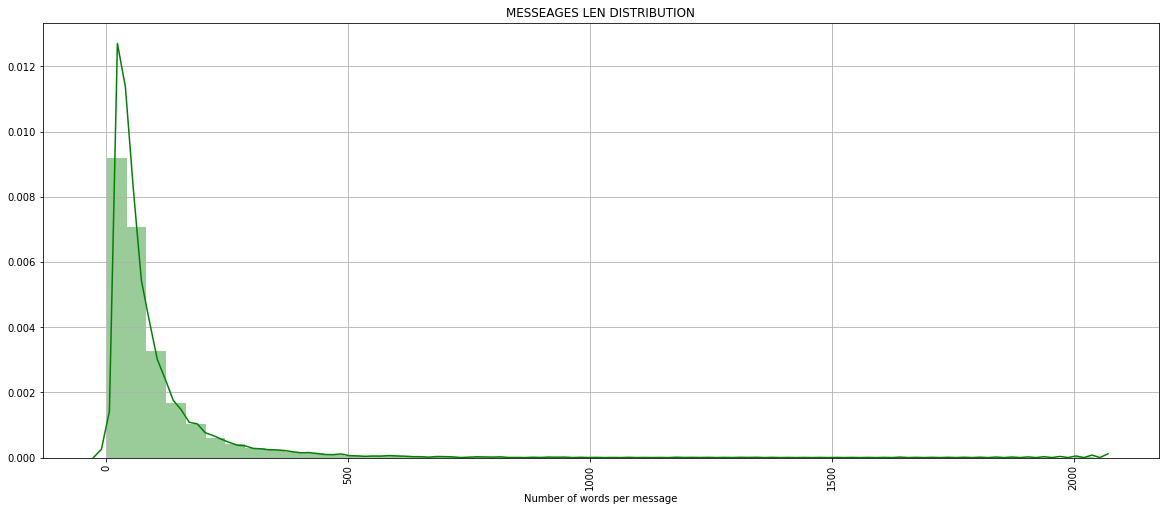

In [239]:
# Creating a column to see the len of each message
reviews['Len'] = reviews['reviewText'].apply(lambda x: len(x.split(' ')))

# Senteces Distribution
unique = reviews['Len'].unique()
plt.figure(figsize=(20,8))
sns.distplot(reviews['Len'],color='green')
plt.title('MESSEAGES LEN DISTRIBUTION')
plt.xlabel('Number of words per message')
plt.grid()
plt.xticks(rotation=90)
plt.show()

most of the reviews are quite short. usually less than 100 characters so people don't go too far when typing.

#### **CREATING MODEL**

In [240]:
seed = random.seed(42)

In [241]:
# Creating the inputa Array of values and the target
X = reviews['reviewText']
y = reviews['Sentiment']

#### TF-IDF & CountVectorizer

In [242]:
# Fitting TF-IDF algorithm
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(X)

#### **Target Class Check**

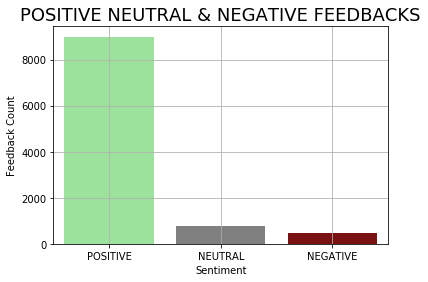

In [243]:
# Plotting Target Class
pos_neg_color = ['lightgreen','gray','darkred']
sns.countplot(data=reviews, x='Sentiment',palette= pos_neg_color)
plt.title('POSITIVE NEUTRAL & NEGATIVE FEEDBACKS', size=18)
plt.ylabel('Feedback Count')
plt.grid()
plt.show()

we are facing an umbalanced target variable. Let´s apply **SMOTE**. This stands for Synthetic Minority Oversampling Technique, or SMOTE for short.

In [244]:
# Applying Smote
smote = SMOTE(random_state= seed)
X_smote, y_smote = smote.fit_resample(X,y)

In [245]:
# Counting Target Variable
y_smote.value_counts()

NEGATIVE    8991
POSITIVE    8991
NEUTRAL     8991
Name: Sentiment, dtype: int64

In [246]:
# Traind and test split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size= 0.3, random_state= seed)

print('X_train shape ', X_train.shape)
print('y_train shape ', y_train.shape)
print('X_test shape ', X_test.shape)
print('y_test shape ', y_test.shape)

X_train shape  (18881, 20244)
y_train shape  (18881,)
X_test shape  (8092, 20244)
y_test shape  (8092,)


####  **Logistic Regression Algorithm**

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


LOGISTIC REGRESSION


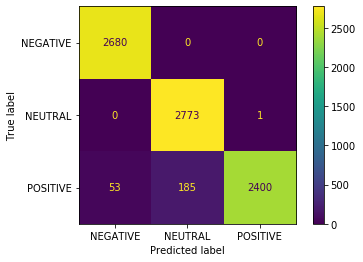


Classification Report
              precision    recall  f1-score   support

    NEGATIVE       0.98      1.00      0.99      2680
     NEUTRAL       0.94      1.00      0.97      2774
    POSITIVE       1.00      0.91      0.95      2638

    accuracy                           0.97      8092
   macro avg       0.97      0.97      0.97      8092
weighted avg       0.97      0.97      0.97      8092

Model Accuracy:  0.9704646564508156


In [247]:
#Creating Classifier
logistic_regression = LogisticRegressionCV(random_state= seed, verbose= 1) 

#Fitting Model
logistic_regression.fit(X_train,y_train)

#Prediction
prediction = logistic_regression.predict(X_test)

#Model Accuracy
print('LOGISTIC REGRESSION')
plot_confusion_matrix(logistic_regression, X_test, y_test)  
plt.show()

print()
print('Classification Report')
print(classification_report(y_test, prediction))
print('Model Accuracy: ',accuracy_score(y_test,prediction))

In [248]:
# Checking Predictions with random reviews
test_set = ['very bad cable, didn´t expected it had a blue light, and also to expensive', #Negative Comment
            'this really rocks!, product was like i expected, power cable is perfect', # Positive Comment
            'wasn´t expecting Fender guitar, but is ok, next time i will check the comments'] # Neutral Comment  

# fitting TF-IDF
new_test = vectorizer.transform(test_set)
          

print('Logistic Regression prediction',logistic_regression.predict(new_test))

Logistic Regression prediction ['NEGATIVE' 'POSITIVE' 'NEUTRAL']


#### **Random Forest Classifier**

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   55.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RANDOM FOREST CLASSIFIER


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished


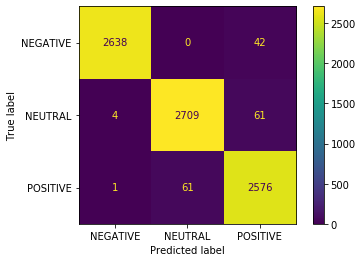


Classification Report
              precision    recall  f1-score   support

    NEGATIVE       1.00      0.98      0.99      2680
     NEUTRAL       0.98      0.98      0.98      2774
    POSITIVE       0.96      0.98      0.97      2638

    accuracy                           0.98      8092
   macro avg       0.98      0.98      0.98      8092
weighted avg       0.98      0.98      0.98      8092

Model Accuracy:  0.9791151754819575


In [249]:
#Creating classifier
random_forest_classifier = RandomForestClassifier(random_state=seed, n_estimators=200,verbose=1)
random_forest_classifier.fit(X_train, y_train)

#Prediction
random_prediction = random_forest_classifier.predict(X_test)

#Model Accuracy
print('RANDOM FOREST CLASSIFIER')
plot_confusion_matrix(random_forest_classifier, X_test, y_test)  
plt.show() 

print()
print('Classification Report')
print(classification_report(y_test, random_prediction))
print('Model Accuracy: ',accuracy_score(y_test, random_prediction))

In [252]:
# Checking Predictions with random reviews
test_set = ['very bad cable, didn´t expected it had a blue light, and also to expensive', #Negative Comment
            'this really rocks!, product was like i expected, power cable is perfect', # Positive Comment
            'wasn´t expecting Fender guitar, but is ok, next time i will check the comments'] # Neutral Comment  

# fitting TF-IDF
new_test = vectorizer.transform(test_set)
          

print('Random forest prediction',random_forest_classifier.predict(new_test))

Random forest prediction ['POSITIVE' 'POSITIVE' 'POSITIVE']


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


It can be seen that our random forest model has not been very effective, since all the texts with which we have tested have been recognized as positive. For what our model has a bias towards positive feedback, the SMOT has not worked correctly. 

In [253]:
#Saving Logistic Regression Model.
filename = 'logistic_sentiment_model.pkl'
pickle.dump(logistic_regression, open(filename, 'wb'))